In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pandas as pd
import numpy as np
import glob
from tqdm import tqdm
import xarray as xr
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import torch
from glob import glob
import seaborn as sns
import rasterio as rio
import geopandas as gpd

import deep_snow.dataset

In [2]:
w_path = "/mnt/c/Users/JackE/uw/courses/aut24/ml_geo/final_data/WDA_data/ASO_50M_SD_Merced_20230131_clean.tif"
s_path = "/mnt/c/Users/JackE/uw/courses/aut24/ml_geo/final_data/WDA_data/ASO_50M_SD_Merced_20210526_clean.tif"

In [3]:
aso_dsw = xr.open_dataset(w_path).squeeze()
aso_dsw = aso_dsw.rename({'band_data': 'aso_sd'})
aso_dsw['aso_sd'] = aso_dsw['aso_sd'].where(aso_dsw['aso_sd'] >= 0)
aso_dss = xr.open_dataset(s_path).squeeze()
aso_dss = aso_dss.rename({'band_data': 'aso_sd'})
aso_dss['aso_sd'] = aso_dss['aso_sd'].where(aso_dss['aso_sd'] >= 0)

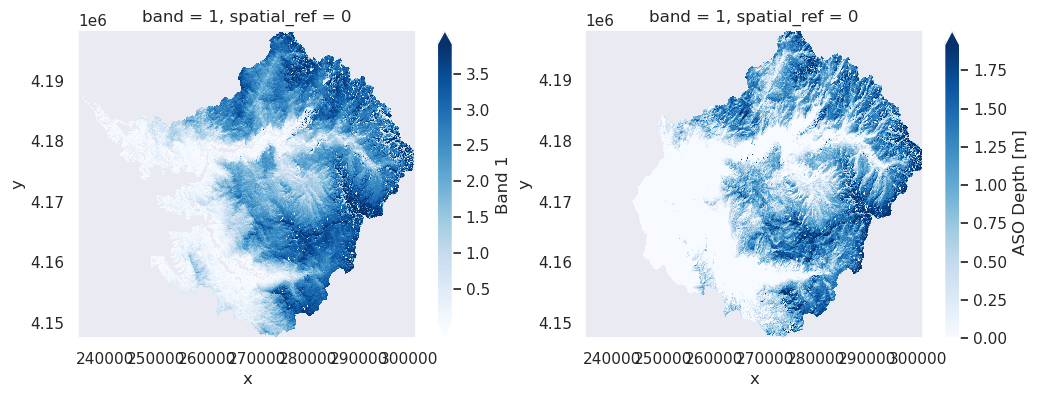

In [117]:
fig, axs = plt.subplots(1,2,figsize=(12,4))
aso_dsw.aso_sd.plot(cmap='Blues', robust=True, ax=axs[0])
aso_dss.aso_sd.plot(cmap='Blues', robust=True, ax=axs[1])
plt.show()

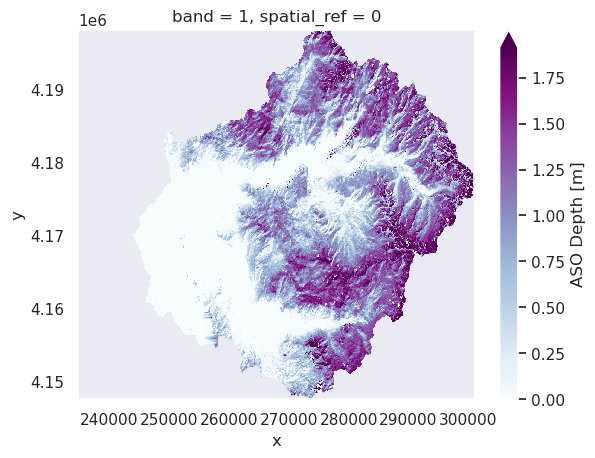

In [76]:
aso_dss.aso_sd.plot(cmap='BuPu', robust=True)

In [80]:
import odc.stac

In [116]:
import xyzservices as xyz
aso_dss.aso_sd.odc.explore(vmax=2, vmin=0, cmap="Blues", tiles=xyz.providers.Esri.WorldImagery, grid=False)

In [7]:
S2_dsw = xr.open_dataset("/mnt/c/Users/JackE/uw/courses/aut24/ml_geo/final_data/WDA_data/20230131_for_ASO_50M_SD_Merced_20230131_clean.nc").squeeze()
S2_dsw = S2_dsw.rio.write_crs(aso_dsw.rio.crs)
S2_dsw = S2_dsw.rio.reproject_match(aso_dss, resampling=rio.enums.Resampling.bilinear, crs=aso_dss.rio.crs) 
S2_dss = xr.open_dataset("/mnt/c/Users/JackE/uw/courses/aut24/ml_geo/final_data/WDA_data/20210526_for_ASO_50M_SD_Merced_20210526_clean.nc").squeeze()
S2_dss = S2_dss.rio.write_crs(aso_dss.rio.crs)
S2_dss = S2_dss.rio.reproject_match(aso_dss, resampling=rio.enums.Resampling.bilinear, crs=aso_dss.rio.crs) 

In [8]:
# Convert the DataArray objects to PyTorch tensors
wB04_tensor = torch.tensor(S2_dsw.B04.values)
wB03_tensor = torch.tensor(S2_dsw.B03.values)
wB02_tensor = torch.tensor(S2_dsw.B02.values)
# Perform the normalization and add an extra dimension for RGB channels
norm_maxw = np.max([wB04_tensor.max(), wB03_tensor.max(), wB02_tensor.max()])
wB04_tensor = (wB04_tensor / norm_maxw).unsqueeze(2)  # Add a channel dimension
wB03_tensor = (wB03_tensor / norm_maxw).unsqueeze(2)  # Add a channel dimension
wB02_tensor = (wB02_tensor / norm_maxw).unsqueeze(2)  # Add a channel dimension
# Concatenate along the third dimension (channel)
wrgb_tensor = torch.cat((wB04_tensor, wB03_tensor, wB02_tensor), dim=2).squeeze()

sB04_tensor = torch.tensor(S2_dss.B04.values)
sB03_tensor = torch.tensor(S2_dss.B03.values)
sB02_tensor = torch.tensor(S2_dss.B02.values)
norm_maxs = np.max([sB04_tensor.max(), sB03_tensor.max(), sB02_tensor.max()])
sB04_tensor = (sB04_tensor / norm_maxs).unsqueeze(2)
sB03_tensor = (sB03_tensor / norm_maxs).unsqueeze(2)
sB02_tensor = (sB02_tensor / norm_maxs).unsqueeze(2)
srgb_tensor = torch.cat((sB04_tensor, sB03_tensor, sB02_tensor), dim=2).squeeze()

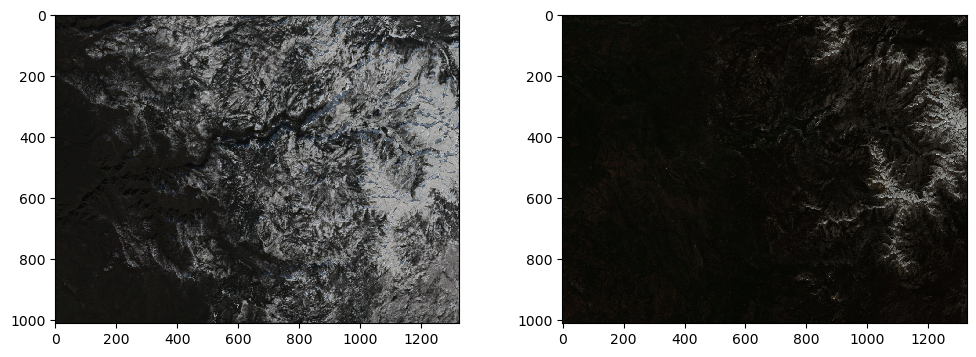

In [9]:
fig, axs = plt.subplots(1,2,figsize=(12,4))
axs[0].imshow(wrgb_tensor, interpolation='none')
axs[1].imshow(srgb_tensor, interpolation='none')
plt.show()

In [20]:
import contextily as ctx
ctx.providers.Esri

{'WorldStreetMap': {'url': 'https://server.arcgisonline.com/ArcGIS/rest/services/{variant}/MapServer/tile/{z}/{y}/{x}',
  'variant': 'World_Street_Map',
  'html_attribution': 'Tiles &copy; Esri &mdash; Source: Esri, DeLorme, NAVTEQ, USGS, Intermap, iPC, NRCAN, Esri Japan, METI, Esri China (Hong Kong), Esri (Thailand), TomTom, 2012',
  'attribution': 'Tiles (C) Esri -- Source: Esri, DeLorme, NAVTEQ, USGS, Intermap, iPC, NRCAN, Esri Japan, METI, Esri China (Hong Kong), Esri (Thailand), TomTom, 2012',
  'name': 'Esri.WorldStreetMap'},
 'WorldTopoMap': {'url': 'https://server.arcgisonline.com/ArcGIS/rest/services/{variant}/MapServer/tile/{z}/{y}/{x}',
  'variant': 'World_Topo_Map',
  'html_attribution': 'Tiles &copy; Esri &mdash; Esri, DeLorme, NAVTEQ, TomTom, Intermap, iPC, USGS, FAO, NPS, NRCAN, GeoBase, Kadaster NL, Ordnance Survey, Esri Japan, METI, Esri China (Hong Kong), and the GIS User Community',
  'attribution': 'Tiles (C) Esri -- Esri, DeLorme, NAVTEQ, TomTom, Intermap, iPC, USGS, FAO, NPS, NRCAN, GeoBase, Kadaster NL, Ordnance Survey, Esri Japan, METI, Esri China (Hong Kong), and the GIS User Community',
  'name': 'Esri.WorldTopoMap'},
 'WorldImagery': {'url': 'https://server.arcgisonline.com/ArcGIS/rest/services/{variant}/MapServer/tile/{z}/{y}/{x}',
  'variant': 'World_Imagery',
  'html_attribution': 'Tiles &copy; Esri &mdash; Source: Esri, i-cubed, USDA, USGS, AEX, GeoEye, Getmapping, Aerogrid, IGN, IGP, UPR-EGP, and the GIS User Community',
  'attribution': 'Tiles (C) Esri -- Source: Esri, i-cubed, USDA, USGS, AEX, GeoEye, Getmapping, Aerogrid, IGN, IGP, UPR-EGP, and the GIS User Community',
  'name': 'Esri.WorldImagery'},
 'WorldTerrain': {'url': 'https://server.arcgisonline.com/ArcGIS/rest/services/{variant}/MapServer/tile/{z}/{y}/{x}',
  'variant': 'World_Terrain_Base',
  'html_attribution': 'Tiles &copy; Esri &mdash; Source: USGS, Esri, TANA, DeLorme, and NPS',
  'attribution': 'Tiles (C) Esri -- Source: USGS, Esri, TANA, DeLorme, and NPS',
  'max_zoom': 13,
  'name': 'Esri.WorldTerrain'},
 'WorldShadedRelief': {'url': 'https://server.arcgisonline.com/ArcGIS/rest/services/{variant}/MapServer/tile/{z}/{y}/{x}',
  'variant': 'World_Shaded_Relief',
  'html_attribution': 'Tiles &copy; Esri &mdash; Source: Esri',
  'attribution': 'Tiles (C) Esri -- Source: Esri',
  'max_zoom': 13,
  'name': 'Esri.WorldShadedRelief'},
 'WorldPhysical': {'url': 'https://server.arcgisonline.com/ArcGIS/rest/services/{variant}/MapServer/tile/{z}/{y}/{x}',
  'variant': 'World_Physical_Map',
  'html_attribution': 'Tiles &copy; Esri &mdash; Source: US National Park Service',
  'attribution': 'Tiles (C) Esri -- Source: US National Park Service',
  'max_zoom': 8,
  'name': 'Esri.WorldPhysical'},
 'OceanBasemap': {'url': 'https://server.arcgisonline.com/ArcGIS/rest/services/{variant}/MapServer/tile/{z}/{y}/{x}',
  'variant': 'Ocean/World_Ocean_Base',
  'html_attribution': 'Tiles &copy; Esri &mdash; Sources: GEBCO, NOAA, CHS, OSU, UNH, CSUMB, National Geographic, DeLorme, NAVTEQ, and Esri',
  'attribution': 'Tiles (C) Esri -- Sources: GEBCO, NOAA, CHS, OSU, UNH, CSUMB, National Geographic, DeLorme, NAVTEQ, and Esri',
  'max_zoom': 13,
  'name': 'Esri.OceanBasemap'},
 'NatGeoWorldMap': {'url': 'https://server.arcgisonline.com/ArcGIS/rest/services/{variant}/MapServer/tile/{z}/{y}/{x}',
  'variant': 'NatGeo_World_Map',
  'html_attribution': 'Tiles &copy; Esri &mdash; National Geographic, Esri, DeLorme, NAVTEQ, UNEP-WCMC, USGS, NASA, ESA, METI, NRCAN, GEBCO, NOAA, iPC',
  'attribution': 'Tiles (C) Esri -- National Geographic, Esri, DeLorme, NAVTEQ, UNEP-WCMC, USGS, NASA, ESA, METI, NRCAN, GEBCO, NOAA, iPC',
  'max_zoom': 16,
  'name': 'Esri.NatGeoWorldMap'},
 'WorldGrayCanvas': {'url': 'https://server.arcgisonline.com/ArcGIS/rest/services/{variant}/MapServer/tile/{z}/{y}/{x}',
  'variant': 'Canvas/World_Light_Gray_Base',
  'html_attribution': 'Tiles &copy; Esri &mdash; Esri, DeLorme, NAVTEQ',
  'attribution': 'Tiles (C) Esri -- Esri, DeLorme, NAVTE

<function matplotlib.pyplot.show(close=None, block=None)>

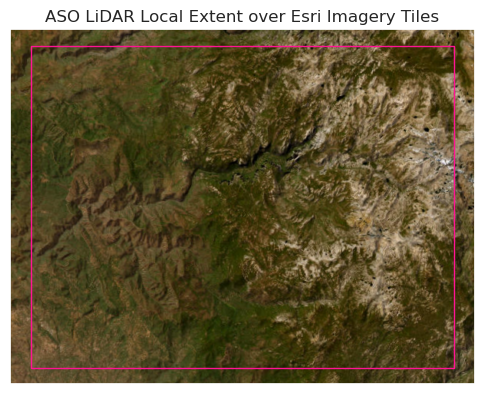

In [140]:
from shapely.geometry import box
import contextily  as ctx
fig, ax = plt.subplots(figsize=(6, 6))
bbox = aso_dsw.aso_sd.rio.bounds()
bounds_box = box(bbox[0], bbox[1], bbox[2], bbox[3])
gpd.GeoSeries(bounds_box).plot(ax=ax, facecolor='none', edgecolor='deeppink')
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('')
ax.set_ylabel('')
ctx.add_basemap(ax=ax, crs=aso_dsw.rio.crs, source=ctx.providers.Esri.WorldImagery, attribution=False)
ax.set_title("ASO LiDAR Local Extent over Esri Imagery Tiles")
plt.savefig('/mnt/c/Users/JackE/uw/courses/aut24/ml_geo/final_data/WDA_data/images_hw6/aso_extent_local.png', bbox_inches='tight', dpi=200)
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

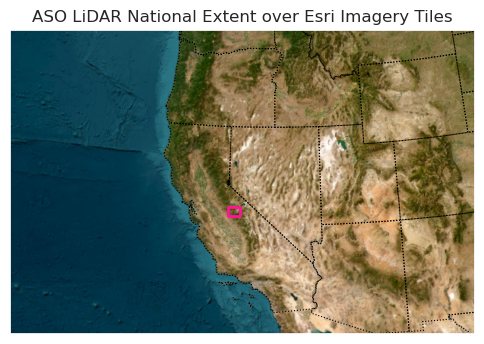

In [141]:
fig, ax = plt.subplots(figsize=(6, 6))
states = gpd.read_file("/mnt/c/Users/JackE/uw/STV/data/cb_2018_us_state_5m")
states.to_crs(aso_dss.rio.crs).plot(ax=ax, facecolor='none', edgecolor='black', linewidth=0.8, linestyle=":")
bbox = aso_dsw.aso_sd.rio.bounds()
bounds_box = box(bbox[0], bbox[1], bbox[2], bbox[3])
gpd.GeoSeries(bounds_box).plot(ax=ax, facecolor='none', edgecolor='deeppink', linewidth=2)
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_xlim(-1e6, 1.63e6)
ax.set_ylim(3.48e6 , 5.2e6)
ctx.add_basemap(ax=ax, crs=aso_dsw.rio.crs, source=ctx.providers.Esri.WorldImagery, attribution=False)
ax.set_title("ASO LiDAR National Extent over Esri Imagery Tiles")
plt.savefig('/mnt/c/Users/JackE/uw/courses/aut24/ml_geo/final_data/WDA_data/images_hw6/aso_extent_national.png', bbox_inches='tight', dpi=200)
plt.show

In [ ]:
# grab data paths
data_dir = '/mnt/c/Users/JackE/uw/courses/aut24/ml_geo/final_data/WDA_data/wint'
path_list = glob(f'{data_dir}/ASO_50M_SD*.nc')

In [28]:
# define data to be returned by dataloader
selected_channels = [
    # ASO products
    'aso_sd', # ASO lidar snow depth (target dataset)
    'aso_gap_map', # gaps in ASO data
    
    # Sentinel-1 products
    'snowon_vv', # snow on Sentinel-1 VV polarization backscatter in dB, closest acquisition to ASO acquisition
    'snowon_vh', # snow on Sentinel-1 VH polarization backscatter in dB, closest acquisition to ASO acquisition
    'snowoff_vv', # snow off Sentinel-1 VV polarization backscatter in dB, closest acquisition to ASO acquisition
    'snowoff_vh', # snow off Sentinel-1 VH polarization backscatter in dB, closest acquisition to ASO acquisition
    'snowon_cr', # cross ratio, snowon_vh - snowon_vv
    'snowoff_cr', # cross ratio, snowoff_vh - snowoff_vv
    'delta_cr', # change in cross ratio, snowon_cr - snowoff_cr
    'rtc_gap_map', # gaps in Sentinel-1 data
    
    # Sentinel-2 products 
    'aerosol_optical_thickness', # snow on Sentinel-2 aerosol optical thickness band 
    'coastal_aerosol', # snow on Sentinel-2 coastal aerosol band
    'blue', # snow on Sentinel-2 blue band
    'green', # snow on Sentinel-2 green band
    'red', # snow on Sentinel-2 red band
    'red_edge1', # snow on Sentinel-2 red edge 1 band
    'red_edge2', # snow on Sentinel-2 red edge 2 band
    'red_edge3', # snow on Sentinel-2 red edge 3 band
    'nir', # snow on Sentinel-2 near infrared band
    'water_vapor', # snow on Sentinel-2 water vapor
    'swir1', # snow on Sentinel-2 shortwave infrared band 1
    'swir2', # snow on Sentinel-2 shortwave infrared band 2
    'scene_class_map', # snow on Sentinel-2 scene classification product
    'water_vapor_product', # snow on Sentinel-2 water vapor product
    'ndvi', # Normalized Difference Vegetation Index from Sentinel-2
    'ndsi', # Normalized Difference Snow Index from Sentinel-2
    'ndwi', # Normalized Difference Water Index from Sentinel-2
    's2_gap_map', # gaps in Sentinel-2 data

    # PROBA-V global land cover dataset (Buchhorn et al., 2020)
    'fcf', # fractional forest cover
    
    # COP30 digital elevation model      
    'elevation',
    'slope',
    'aspect',
    'curvature',
    'tpi',
    'tri',

    # latitude and longitude
    'latitude',
    'longitude',

    # day of water year
    'dowy'
                    ]

# prepare training and validation dataloaders
train_data = deep_snow.dataset.Dataset(path_list, selected_channels, norm=True)
train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=1, shuffle=True)

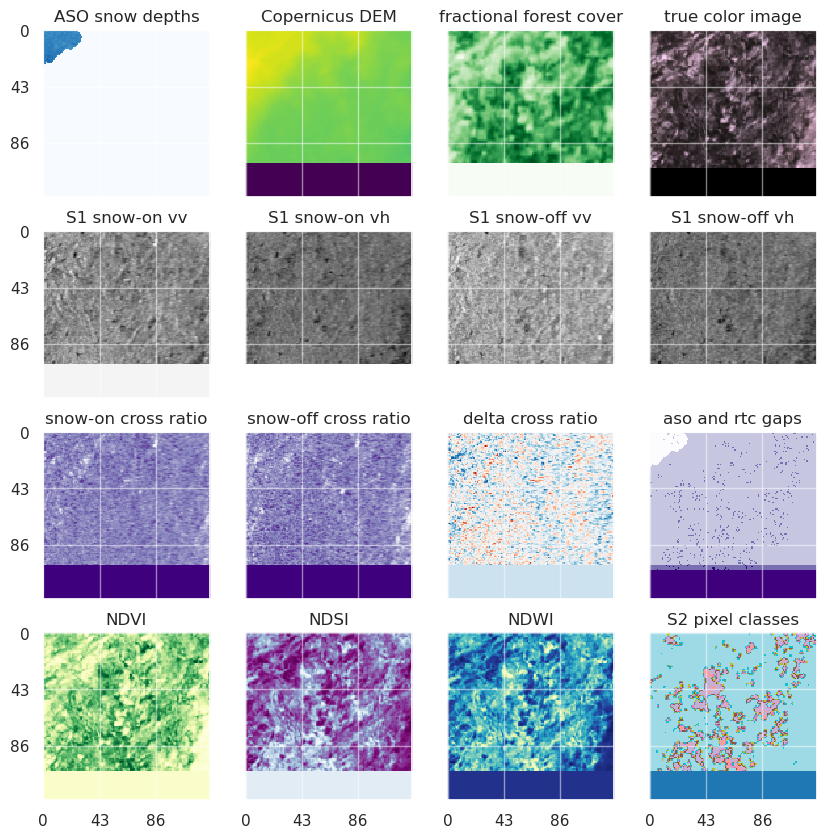

In [29]:
sns.set_theme()
num_samples = 1

for i, data_tuple in enumerate(train_loader):
    if i < num_samples:
        data_dict = {name: tensor.squeeze() for name, tensor in zip(selected_channels, data_tuple)}
        f, ax = plt.subplots(4, 4, figsize=(10, 10), sharey=True, sharex=True)
        
        ax[0, 0].imshow(data_dict['aso_sd'], vmin=0, vmax=0.2, cmap='Blues', interpolation='none')
        ax[0, 0].set_title('ASO snow depths')
        ax[0, 1].imshow(data_dict['elevation'], cmap='viridis', interpolation='none')
        ax[0, 1].set_title('Copernicus DEM')
        ax[0, 2].imshow(data_dict['fcf'], cmap='Greens', interpolation='none')
        ax[0, 2].set_title('fractional forest cover')
        norm_max = np.max([data_dict['green'].max(), data_dict['red'].max(), data_dict['blue'].max()]) # there are better ways to do this
        ax[0, 3].imshow(torch.cat((data_dict['red'][:, :, None]/norm_max, data_dict['green'][:, :, None]/norm_max, data_dict['blue'][:, :, None]/norm_max), 2).squeeze(), interpolation='none')
        ax[0, 3].set_title('true color image')
        ax[1, 0].imshow(data_dict['snowon_vv'], cmap='Greys_r', interpolation='none')
        ax[1, 0].set_title('S1 snow-on vv')
        ax[1, 1].imshow(data_dict['snowon_vh'], cmap='Greys_r', interpolation='none')
        ax[1, 1].set_title('S1 snow-on vh')
        ax[1, 2].imshow(data_dict['snowoff_vv'], cmap='Greys_r', interpolation='none')
        ax[1, 2].set_title('S1 snow-off vv')
        ax[1, 3].imshow(data_dict['snowoff_vh'], cmap='Greys_r', interpolation='none')
        ax[1, 3].set_title('S1 snow-off vh')
        ax[2, 0].imshow(data_dict['snowon_cr'], cmap='Purples', interpolation='none')
        ax[2, 0].set_title('snow-on cross ratio')
        ax[2, 1].imshow(data_dict['snowoff_cr'], cmap='Purples', interpolation='none')
        ax[2, 1].set_title('snow-off cross ratio')
        ax[2, 2].imshow(data_dict['delta_cr'], cmap='RdBu', interpolation='none')
        ax[2, 2].set_title('delta cross ratio')
        ax[2, 3].imshow(data_dict['aso_gap_map'] + data_dict['rtc_gap_map'] + data_dict['s2_gap_map'], vmin=0, cmap='Purples', interpolation='none')
        ax[2, 3].set_title('aso and rtc gaps')
        ax[3, 0].imshow(data_dict['ndvi'], cmap='YlGn', interpolation='none')
        ax[3, 0].set_title('NDVI')
        ax[3, 1].imshow(data_dict['ndsi'], cmap='BuPu', interpolation='none')
        ax[3, 1].set_title('NDSI')
        ax[3, 2].imshow(data_dict['ndwi'], cmap='YlGnBu', interpolation='none')
        ax[3, 2].set_title('NDWI')
        ax[3, 2].imshow(data_dict['ndwi'], cmap='YlGnBu', interpolation='none')
        ax[3, 2].set_title('NDWI')
        ax[3, 3].imshow(data_dict['scene_class_map'], cmap='tab20', interpolation='none')
        ax[3, 3].set_title('S2 pixel classes')
        ax[0, 0].set_aspect('equal')
        
        # Set gridlines at intervals
        for a in ax.flat:
            a.set_xticks(np.arange(0, data_dict['aso_sd'].shape[1], 43))
            a.set_yticks(np.arange(0, data_dict['aso_sd'].shape[0], 43))
            a.grid(True, linewidth=1, alpha=0.5)
        
        # f.tight_layout()
    else:
        break

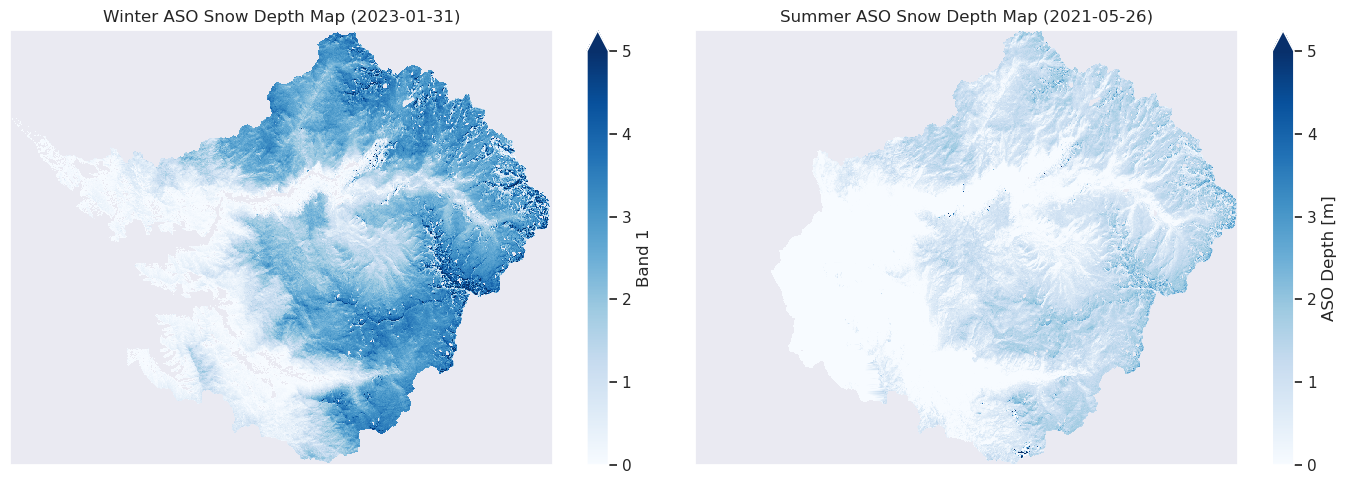

In [126]:
fig, axs = plt.subplots(1,2,figsize=(14,5))
ax=axs[0]
aso_dsw.aso_sd.plot(cmap='Blues', vmin=0, vmax=5, robust=True, ax=ax)
ax.set_yticks([])
ax.set_xticks([])
ax.set_ylabel("")
ax.set_xlabel("")
ax.set_title("Winter ASO Snow Depth Map (2023-01-31)")

ax=axs[1]
aso_dss.aso_sd.plot(cmap='Blues', vmin=0, vmax=5, robust=True, ax=ax)
ax.set_yticks([])
ax.set_xticks([])
ax.set_ylabel("")
ax.set_xlabel("")
ax.set_title("Summer ASO Snow Depth Map (2021-05-26)")
plt.tight_layout()
plt.show()

/tmp/ipykernel_24567/3591682306.py:34: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to make space for colorbar


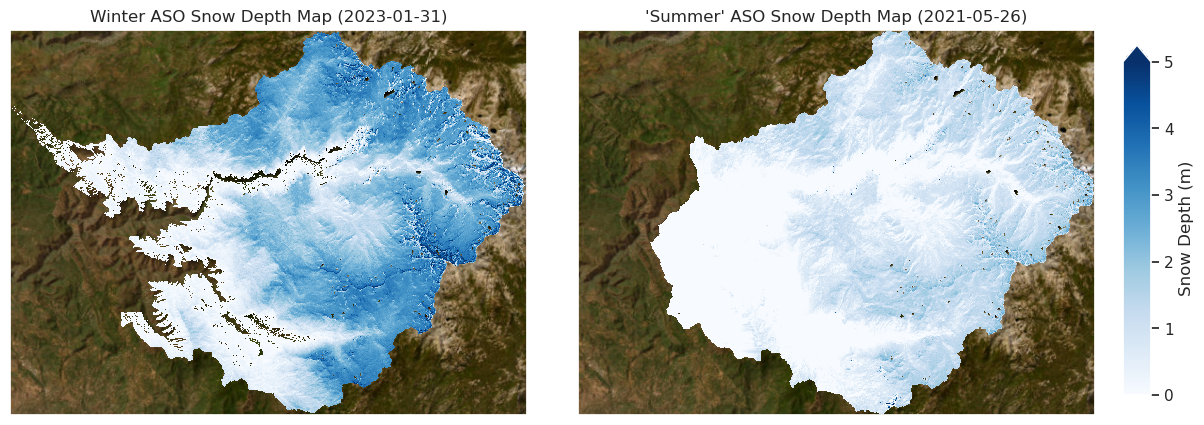

In [136]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Create a figure with space for a shared colorbar
fig = plt.figure(figsize=(14, 5))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1], wspace=0.1)
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # Position for the colorbar

# Winter Snow Depth Map
ax1 = fig.add_subplot(gs[0])
im_winter = aso_dsw.aso_sd.plot(cmap='Blues', vmin=0, vmax=5, robust=True, ax=ax1, cbar_ax=cbar_ax)
ctx.add_basemap(ax=ax1, crs=aso_dsw.rio.crs, source=ctx.providers.Esri.WorldImagery, attribution=False)

ax1.set_yticks([])
ax1.set_xticks([])
ax1.set_ylabel("")
ax1.set_xlabel("")
ax1.set_title("Winter ASO Snow Depth Map (2023-01-31)")

# Summer Snow Depth Map
ax2 = fig.add_subplot(gs[1])
aso_dss.aso_sd.plot(cmap='Blues', vmin=0, vmax=5, robust=True, ax=ax2, add_colorbar=False)
ctx.add_basemap(ax=ax2, crs=aso_dsw.rio.crs, source=ctx.providers.Esri.WorldImagery, attribution=False)
ax2.set_yticks([])
ax2.set_xticks([])
ax2.set_ylabel("")
ax2.set_xlabel("")
ax2.set_title("'Summer' ASO Snow Depth Map (2021-05-26)")

# Set colorbar label
cbar = im_winter.colorbar
cbar.set_label("Snow Depth (m)")

plt.tight_layout()  # Adjust layout to make space for colorbar
plt.savefig('/mnt/c/Users/JackE/uw/courses/aut24/ml_geo/final_data/WDA_data/images_hw6/aso_maps.png', bbox_inches='tight', dpi=400)
plt.show()

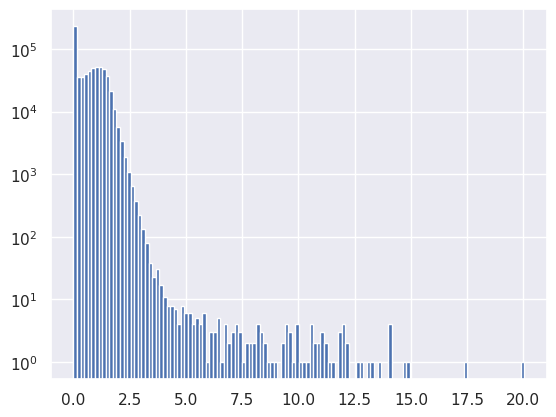

In [77]:
arr = aso_dss['aso_sd'].values.flatten()
arr = arr[~np.isnan(arr)]
plt.hist(arr, bins=np.linspace(arr.min(), arr.max(), 127), log=True)
plt.show()

In [42]:
np.sort(arr)[::-1]

array([20.043856, 17.418358, 14.826053, ...,  0.      ,  0.      ,
        0.      ], dtype=float32)

682127 523


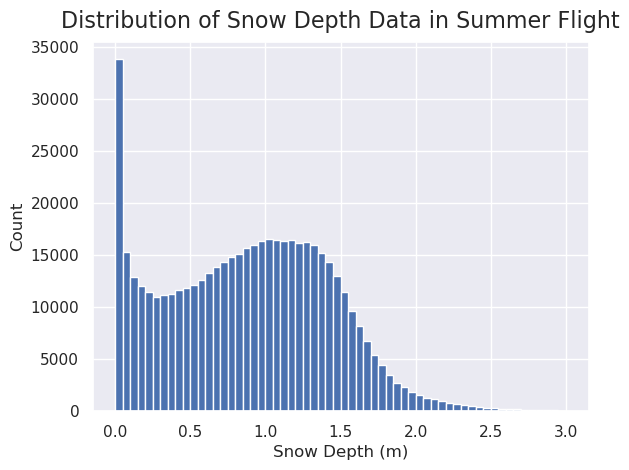

In [111]:
arr = aso_dss['aso_sd'].values.flatten()
arr = arr[~np.isnan(arr)]
print(len(arr), len(arr[arr >= 3]))
arr = arr[arr < 3]
arr = arr[arr > 0]
plt.hist(arr, bins=np.linspace(arr.min(), arr.max(), 61))
plt.title("Distribution of Snow Depth Data in Summer Flight", fontsize=16, pad=10)
plt.xlabel("Snow Depth (m)")
plt.ylabel("Count")
plt.savefig('/mnt/c/Users/JackE/uw/courses/aut24/ml_geo/final_data/WDA_data/images_hw6/aso_summer_hist.png', bbox_inches='tight', dpi=200)
plt.show()

682127 130


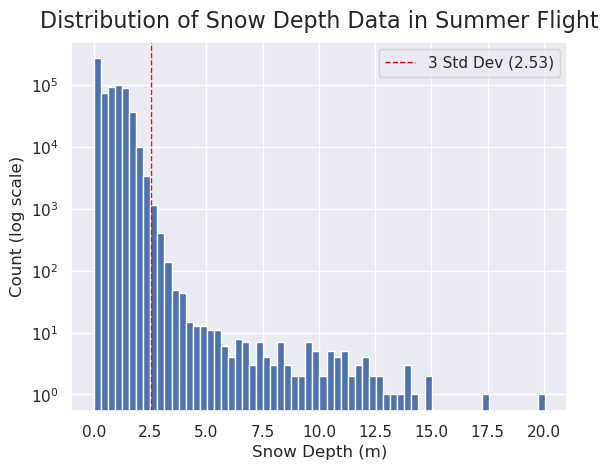

In [142]:
arr = aso_dss['aso_sd'].values.flatten()
arr = arr[~np.isnan(arr)]
#arr = arr[arr > 0]
print(len(arr), len(arr[arr > 5]))
plt.hist(arr, bins=np.linspace(arr.min(), arr.max(), 65), log=True)

mean_arr = np.mean(arr)
std_arr = np.std(arr)
line_position = mean_arr + 3 * std_arr
plt.axvline(line_position, color='red', linestyle='--', linewidth=1, label=f'3 Std Dev ({line_position:.2f})')
plt.legend()

plt.title("Distribution of Snow Depth Data in Summer Flight", fontsize=16, pad=10)
plt.xlabel("Snow Depth (m)")
plt.ylabel("Count (log scale)")
plt.savefig('/mnt/c/Users/JackE/uw/courses/aut24/ml_geo/final_data/WDA_data/images_hw6/aso_summer_hist.png', bbox_inches='tight', dpi=200)
plt.show()

682127 130


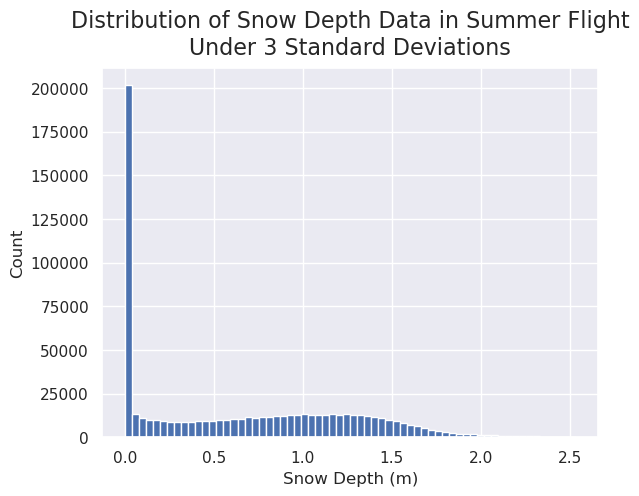

In [143]:
print(len(arr), len(arr[arr > 5]))
plt.hist(arr[arr < line_position], bins=np.linspace(arr[arr < line_position].min(), arr[arr < line_position].max(), 65))

plt.title("Distribution of Snow Depth Data in Summer Flight\nUnder 3 Standard Deviations", fontsize=16, pad=10)
plt.xlabel("Snow Depth (m)")
plt.ylabel("Count")
plt.savefig('/mnt/c/Users/JackE/uw/courses/aut24/ml_geo/final_data/WDA_data/images_hw6/aso_summer_hist2.png', bbox_inches='tight', dpi=200)
plt.show()

632471 2387


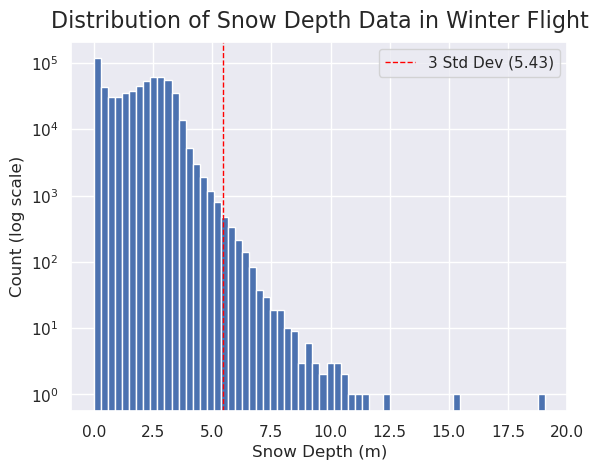

In [144]:
arr = aso_dsw['aso_sd'].values.flatten()
arr = arr[~np.isnan(arr)]
#arr = arr[arr > 0]
print(len(arr), len(arr[arr > 5]))
plt.hist(arr, bins=np.linspace(arr.min(), arr.max(), 65), log=True)

mean_arr = np.mean(arr)
std_arr = np.std(arr)
line_position = mean_arr + 3 * std_arr
plt.axvline(line_position, color='red', linestyle='--', linewidth=1, label=f'3 Std Dev ({line_position:.2f})')
plt.legend()

plt.title("Distribution of Snow Depth Data in Winter Flight", fontsize=16, pad=10)
plt.xlabel("Snow Depth (m)")
plt.ylabel("Count (log scale)")
plt.savefig('/mnt/c/Users/JackE/uw/courses/aut24/ml_geo/final_data/WDA_data/images_hw6/aso_winter_hist.png', bbox_inches='tight', dpi=200)
plt.show()

632471 2387


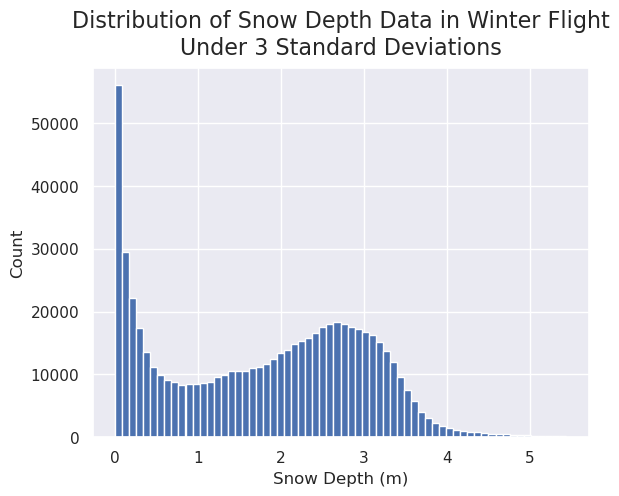

In [145]:
print(len(arr), len(arr[arr > 5]))
plt.hist(arr[arr < line_position], bins=np.linspace(arr[arr < line_position].min(), arr[arr < line_position].max(), 65))

plt.title("Distribution of Snow Depth Data in Winter Flight\nUnder 3 Standard Deviations", fontsize=16, pad=10)
plt.xlabel("Snow Depth (m)")
plt.ylabel("Count")
plt.savefig('/mnt/c/Users/JackE/uw/courses/aut24/ml_geo/final_data/WDA_data/images_hw6/aso_winter_hist2.png', bbox_inches='tight', dpi=200)
plt.show()

In [146]:
sdem_path = "/mnt/c/Users/JackE/uw/courses/aut24/ml_geo/final_data/WDA_data/cop30_for_ASO_50M_SD_Merced_20210526_clean.nc"
sdem_ds = xr.open_dataset(sdem_path).squeeze()
sdem_ds = sdem_ds.rio.write_crs(aso_dss.rio.crs)
sdem_ds = sdem_ds.rename({'__xarray_dataarray_variable__': 'elevation'})
sdem_ds = sdem_ds.rio.reproject_match(aso_dss, resampling=rio.enums.Resampling.bilinear, crs=aso_dss.rio.crs)

wdem_path = "/mnt/c/Users/JackE/uw/courses/aut24/ml_geo/final_data/WDA_data/cop30_for_ASO_50M_SD_Merced_20230131_clean.nc"
wdem_ds = xr.open_dataset(wdem_path).squeeze()
wdem_ds = wdem_ds.rio.write_crs(aso_dsw.rio.crs)
wdem_ds = wdem_ds.rename({'__xarray_dataarray_variable__': 'elevation'})
wdem_ds = wdem_ds.rio.reproject_match(aso_dsw, resampling=rio.enums.Resampling.bilinear, crs=aso_dsw.rio.crs)

In [ ]:
Merced_20210526   Merced_20230131

/tmp/ipykernel_24567/3746041148.py:34: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to make space for colorbar


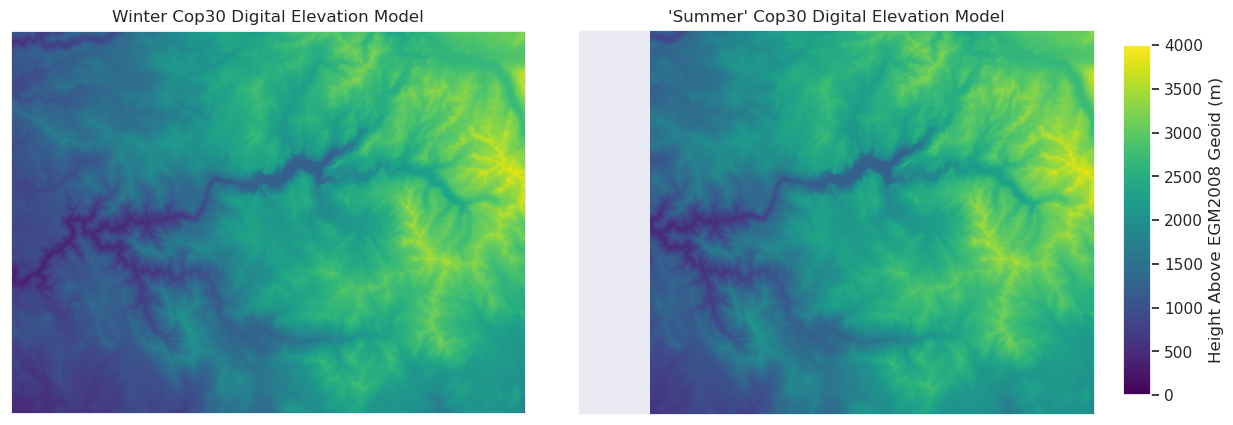

In [156]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Create a figure with space for a shared colorbar
fig = plt.figure(figsize=(14, 5))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1], wspace=0.1)
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # Position for the colorbar

# Winter Snow Depth Map
ax1 = fig.add_subplot(gs[0])
im_winter = wdem_ds.elevation.plot(cmap='viridis', vmin=0, vmax=4000, robust=True, ax=ax1, cbar_ax=cbar_ax)
#ctx.add_basemap(ax=ax1, crs=aso_dsw.rio.crs, source=ctx.providers.Esri.WorldImagery, attribution=False)

ax1.set_yticks([])
ax1.set_xticks([])
ax1.set_ylabel("")
ax1.set_xlabel("")
ax1.set_title("Winter Cop30 Digital Elevation Model")

# Summer Snow Depth Map
ax2 = fig.add_subplot(gs[1])
sdem_ds.elevation.plot(cmap='viridis', vmin=0, vmax=4000, robust=True, ax=ax2, add_colorbar=False)
#ctx.add_basemap(ax=ax2, crs=aso_dsw.rio.crs, source=ctx.providers.Esri.WorldImagery, attribution=False)
ax2.set_yticks([])
ax2.set_xticks([])
ax2.set_ylabel("")
ax2.set_xlabel("")
ax2.set_title("'Summer' Cop30 Digital Elevation Model")

# Set colorbar label
cbar = im_winter.colorbar
cbar.set_label("Height Above EGM2008 Geoid (m)")

plt.tight_layout()  # Adjust layout to make space for colorbar
plt.savefig('/mnt/c/Users/JackE/uw/courses/aut24/ml_geo/final_data/WDA_data/images_hw6/dem_maps.png', bbox_inches='tight', dpi=400)
plt.show()

In [157]:
sfcf_path = "/mnt/c/Users/JackE/uw/courses/aut24/ml_geo/final_data/WDA_data/fcf_for_ASO_50M_SD_Merced_20210526_clean.nc"
sfcf_ds = xr.open_dataset(sfcf_path).squeeze()
sfcf_ds = sfcf_ds.rename({'__xarray_dataarray_variable__': 'fcf'})
sfcf_ds = sfcf_ds.rio.reproject_match(aso_dss, resampling=rio.enums.Resampling.bilinear, crs=aso_dss.rio.crs)

wfcf_path = "/mnt/c/Users/JackE/uw/courses/aut24/ml_geo/final_data/WDA_data/fcf_for_ASO_50M_SD_Merced_20230131_clean.nc"
wfcf_ds = xr.open_dataset(wfcf_path).squeeze()
wfcf_ds = wfcf_ds.rename({'__xarray_dataarray_variable__': 'fcf'})
wfcf_ds = wfcf_ds.rio.reproject_match(aso_dsw, resampling=rio.enums.Resampling.bilinear, crs=aso_dsw.rio.crs)

/tmp/ipykernel_24567/2519966072.py:31: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to make space for colorbar


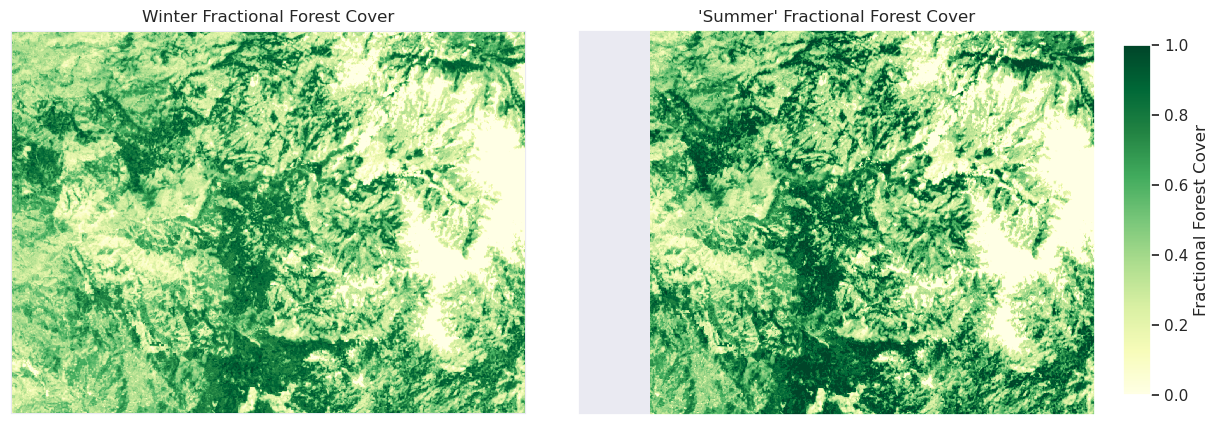

In [162]:
# Create a figure with space for a shared colorbar
fig = plt.figure(figsize=(14, 5))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1], wspace=0.1)
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # Position for the colorbar

# Winter Snow Depth Map
ax1 = fig.add_subplot(gs[0])
im_winter = wfcf_ds.fcf.plot(cmap='YlGn', robust=True, ax=ax1, vmin=0,vmax=1, cbar_ax=cbar_ax)
#ctx.add_basemap(ax=ax1, crs=aso_dsw.rio.crs, source=ctx.providers.Esri.WorldImagery, attribution=False)

ax1.set_yticks([])
ax1.set_xticks([])
ax1.set_ylabel("")
ax1.set_xlabel("")
ax1.set_title("Winter Fractional Forest Cover")

# Summer Snow Depth Map
ax2 = fig.add_subplot(gs[1])
sfcf_ds.fcf.plot(cmap='YlGn', robust=True, ax=ax2, add_colorbar=False)
#ctx.add_basemap(ax=ax2, crs=aso_dsw.rio.crs, source=ctx.providers.Esri.WorldImagery, attribution=False)
ax2.set_yticks([])
ax2.set_xticks([])
ax2.set_ylabel("")
ax2.set_xlabel("")
ax2.set_title("'Summer' Fractional Forest Cover")

# Set colorbar label
cbar = im_winter.colorbar
cbar.set_label("Fractional Forest Cover")

plt.tight_layout()  # Adjust layout to make space for colorbar
plt.savefig('/mnt/c/Users/JackE/uw/courses/aut24/ml_geo/final_data/WDA_data/images_hw6/fcf_maps.png', bbox_inches='tight', dpi=400)
plt.show()

In [182]:
# grab data paths
data_dir = '/mnt/c/Users/JackE/uw/courses/aut24/ml_geo/final_data/WDA_data/wint'
path_list = glob(f'{data_dir}/ASO_50M_SD*.nc')
# define data to be returned by dataloader
selected_channels = [
    # ASO products
    'aso_sd', # ASO lidar snow depth (target dataset)
    'aso_gap_map', # gaps in ASO data
    
    # Sentinel-1 products
    'snowon_vv', # snow on Sentinel-1 VV polarization backscatter in dB, closest acquisition to ASO acquisition
    'snowon_vh', # snow on Sentinel-1 VH polarization backscatter in dB, closest acquisition to ASO acquisition
    'snowoff_vv', # snow off Sentinel-1 VV polarization backscatter in dB, closest acquisition to ASO acquisition
    'snowoff_vh', # snow off Sentinel-1 VH polarization backscatter in dB, closest acquisition to ASO acquisition
    'snowon_cr', # cross ratio, snowon_vh - snowon_vv
    'snowoff_cr', # cross ratio, snowoff_vh - snowoff_vv
    'delta_cr', # change in cross ratio, snowon_cr - snowoff_cr
    'rtc_gap_map', # gaps in Sentinel-1 data
    
    # Sentinel-2 products 
    'aerosol_optical_thickness', # snow on Sentinel-2 aerosol optical thickness band 
    'coastal_aerosol', # snow on Sentinel-2 coastal aerosol band
    'blue', # snow on Sentinel-2 blue band
    'green', # snow on Sentinel-2 green band
    'red', # snow on Sentinel-2 red band
    'red_edge1', # snow on Sentinel-2 red edge 1 band
    'red_edge2', # snow on Sentinel-2 red edge 2 band
    'red_edge3', # snow on Sentinel-2 red edge 3 band
    'nir', # snow on Sentinel-2 near infrared band
    'water_vapor', # snow on Sentinel-2 water vapor
    'swir1', # snow on Sentinel-2 shortwave infrared band 1
    'swir2', # snow on Sentinel-2 shortwave infrared band 2
    'scene_class_map', # snow on Sentinel-2 scene classification product
    'water_vapor_product', # snow on Sentinel-2 water vapor product
    'ndvi', # Normalized Difference Vegetation Index from Sentinel-2
    'ndsi', # Normalized Difference Snow Index from Sentinel-2
    'ndwi', # Normalized Difference Water Index from Sentinel-2
    's2_gap_map', # gaps in Sentinel-2 data

    # PROBA-V global land cover dataset (Buchhorn et al., 2020)
    'fcf', # fractional forest cover
    
    # COP30 digital elevation model      
    'elevation',
    'slope',
    'aspect',
    'curvature',
    'tpi',
    'tri',

    # latitude and longitude
    'latitude',
    'longitude',

    # day of water year
    'dowy'
                    ]

# prepare training and validation dataloaders
train_data = deep_snow.dataset.Dataset(path_list, selected_channels, norm=False)
train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=1, shuffle=True)

# Initialize a dictionary to accumulate all data points for each variable across batches
data_aggregator = {var: [] for var in selected_channels if var != 'aso_gap_map' and var != 'latitude' and var != 'longitude' and var != 'dowy'}
data_aggregator.update({var: [] for var in ['aspect', 'slope', 'tpi']})

# Loop through the dataloader to aggregate data across all batches
for i, data_tuple in enumerate(train_loader):
    # Convert data_tuple to a dictionary and exclude unnecessary variables
    data_dict = {name: tensor.squeeze().numpy() for name, tensor in zip(selected_channels, data_tuple)
                 if name in data_aggregator}
    
    for var_name, data in data_dict.items():
        # Flatten the data and accumulate
        data_aggregator[var_name].extend(data.flatten())

# Compute summary statistics for each variable using the aggregated data
summary_data = []
for var_name, aggregated_data in data_aggregator.items():
    # Convert to a numpy array for consistent operations
    aggregated_data = np.array(aggregated_data)
    
    # Calculate statistics
    summary_data.append({
        'Variable': var_name,
        'Total Count': aggregated_data.size,
        'Mean': np.mean(aggregated_data),
        'Median': np.median(aggregated_data),
        'Range': np.ptp(aggregated_data),  # Peak-to-peak (max - min)
        'Skew': skew(aggregated_data, nan_policy='omit'),
        'Kurtosis': kurtosis(aggregated_data, nan_policy='omit')
    })

# Convert to a DataFrame
summary_df = pd.DataFrame(summary_data)

/tmp/ipykernel_24567/1624384855.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  summary_df[summary_df.select_dtypes(include=['float', 'int']).columns] = summary_df.select_dtypes(include=['float', 'int']).applymap(lambda x: f"{x:.2f}")


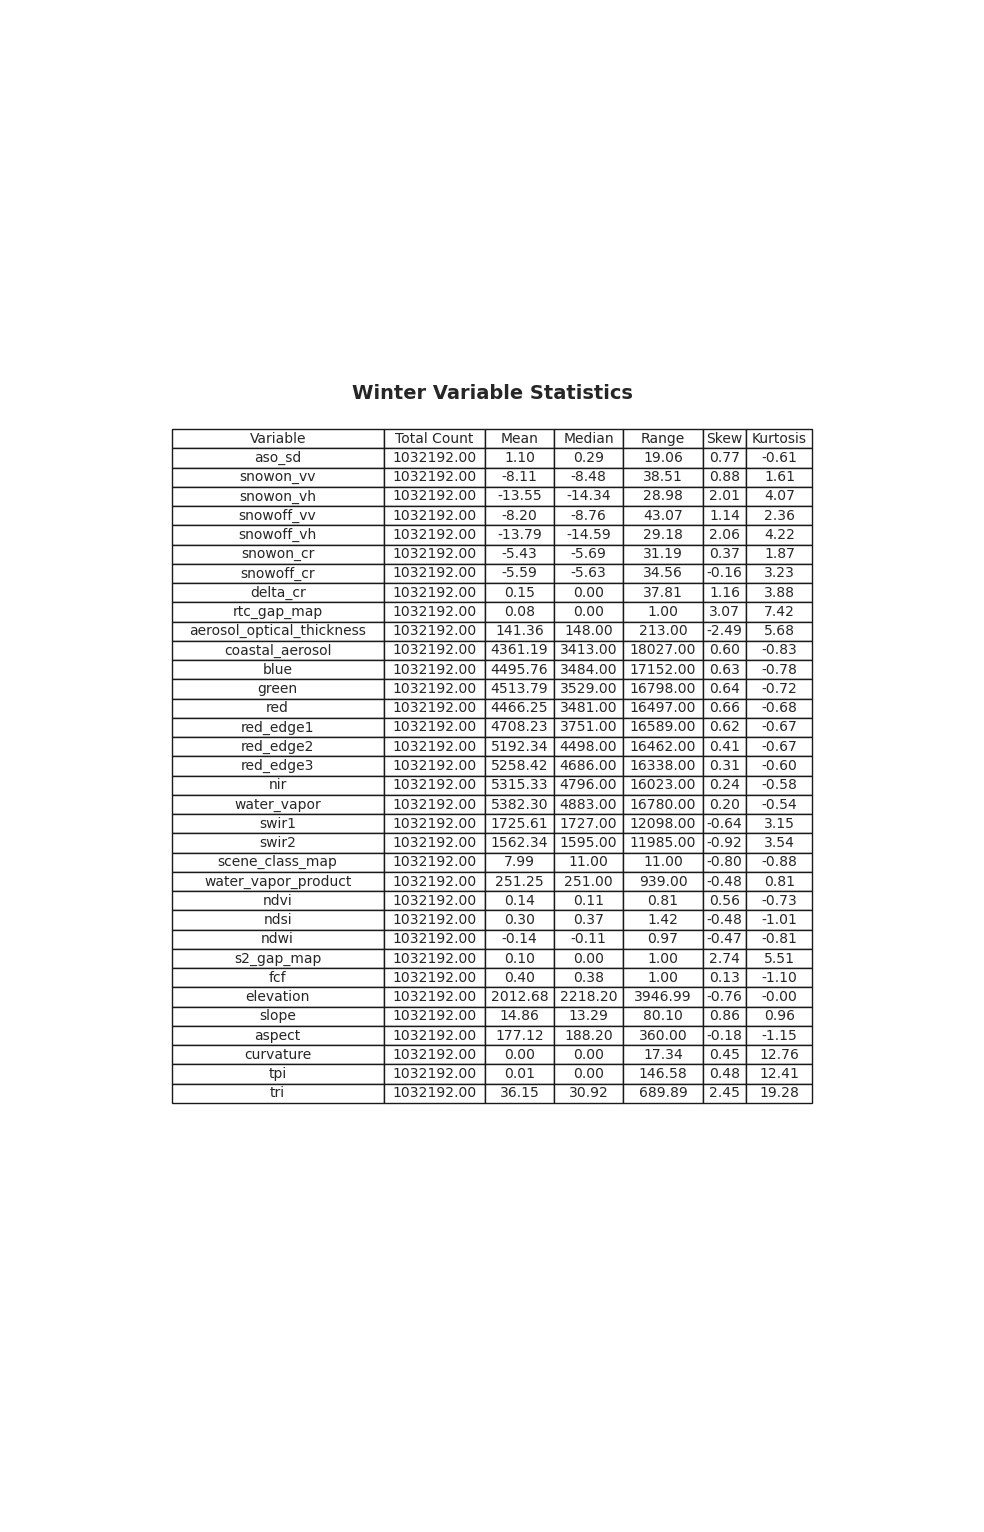

In [201]:
# Round the values in summary_df to 2 decimal points
summary_df[summary_df.select_dtypes(include=['float', 'int']).columns] = summary_df.select_dtypes(include=['float', 'int']).applymap(lambda x: f"{x:.2f}")

# Set up figure and axis
fig, ax = plt.subplots(figsize=(10, len(summary_df) * 0.5))  # Adjust height based on rows

# Set table title
ax.set_title("Winter Variable Statistics", fontsize=14, fontweight='bold', pad=-280)

# Hide axes
ax.axis('off')

# Create the table
table = ax.table(cellText=summary_df.values, colLabels=summary_df.columns, cellLoc='center', loc='center')

# Customize table appearance
table.auto_set_font_size(False)
table.set_fontsize(10)
table.auto_set_column_width(col=list(range(len(summary_df.columns))))

# Adjust layout to reduce whitespace
plt.tight_layout()
fig.subplots_adjust(top=0.9)  # Adjust this value to make space for the title

plt.savefig('/mnt/c/Users/JackE/uw/courses/aut24/ml_geo/final_data/WDA_data/images_hw6/winter_stats.png', bbox_inches='tight', dpi=300)
plt.show()

In [202]:
# grab data paths
data_dir = '/mnt/c/Users/JackE/uw/courses/aut24/ml_geo/final_data/WDA_data/wint'
path_list = glob(f'{data_dir}/ASO_50M_SD*.nc')
# prepare training and validation dataloaders
train_data = deep_snow.dataset.Dataset(path_list, selected_channels, norm=True)
train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=1, shuffle=True)
# Initialize a dictionary to accumulate all data points for each variable across batches
data_aggregator = {var: [] for var in selected_channels if var != 'aso_gap_map' and var != 'latitude' and var != 'longitude' and var != 'dowy'}
data_aggregator.update({var: [] for var in ['aspect', 'slope', 'tpi']})
# Loop through the dataloader to aggregate data across all batches
for i, data_tuple in enumerate(train_loader):
    # Convert data_tuple to a dictionary and exclude unnecessary variables
    data_dict = {name: tensor.squeeze().numpy() for name, tensor in zip(selected_channels, data_tuple)
                 if name in data_aggregator}
    
    for var_name, data in data_dict.items():
        # Flatten the data and accumulate
        data_aggregator[var_name].extend(data.flatten())
# Compute summary statistics for each variable using the aggregated data
summary_data = []
for var_name, aggregated_data in data_aggregator.items():
    # Convert to a numpy array for consistent operations
    aggregated_data = np.array(aggregated_data)
    # Calculate statistics
    summary_data.append({
        'Variable': var_name,
        'Total Count': aggregated_data.size,
        'Mean': np.mean(aggregated_data),
        'Median': np.median(aggregated_data),
        'Range': np.ptp(aggregated_data),  # Peak-to-peak (max - min)
        'Skew': skew(aggregated_data, nan_policy='omit'),
        'Kurtosis': kurtosis(aggregated_data, nan_policy='omit')
    })
# Convert to a DataFrame
summary_df = pd.DataFrame(summary_data)

/tmp/ipykernel_24567/3178098118.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  summary_df[summary_df.select_dtypes(include=['float', 'int']).columns] = summary_df.select_dtypes(include=['float', 'int']).applymap(lambda x: f"{x:.2f}")


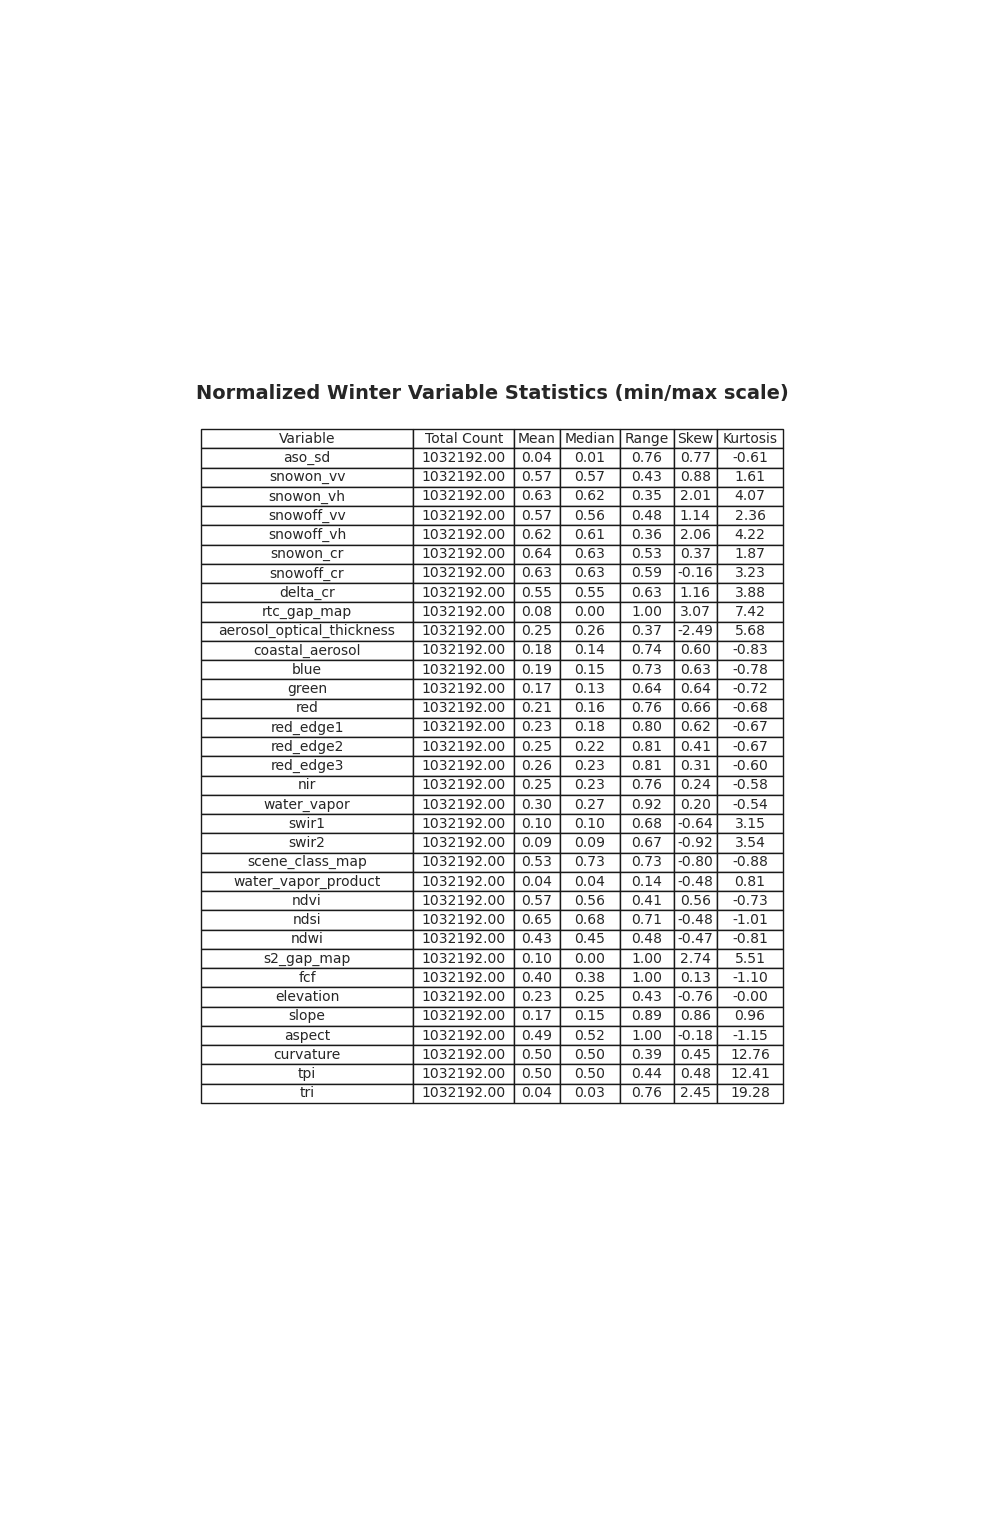

In [203]:
# Round the values in summary_df to 2 decimal points
summary_df[summary_df.select_dtypes(include=['float', 'int']).columns] = summary_df.select_dtypes(include=['float', 'int']).applymap(lambda x: f"{x:.2f}")
fig, ax = plt.subplots(figsize=(10, len(summary_df) * 0.5))  # Adjust height based on rows
ax.set_title("Normalized Winter Variable Statistics (min/max scale)", fontsize=14, fontweight='bold', pad=-280)
ax.axis('off')
table = ax.table(cellText=summary_df.values, colLabels=summary_df.columns, cellLoc='center', loc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.auto_set_column_width(col=list(range(len(summary_df.columns))))
plt.tight_layout()
fig.subplots_adjust(top=0.9)
plt.savefig('/mnt/c/Users/JackE/uw/courses/aut24/ml_geo/final_data/WDA_data/images_hw6/norm_winter_stats.png', bbox_inches='tight', dpi=300)
plt.show()

In [204]:
# grab data paths
data_dir = '/mnt/c/Users/JackE/uw/courses/aut24/ml_geo/final_data/WDA_data/sum'
path_list = glob(f'{data_dir}/ASO_50M_SD*.nc')
# prepare training and validation dataloaders
train_data = deep_snow.dataset.Dataset(path_list, selected_channels, norm=True)
train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=1, shuffle=True)
# Initialize a dictionary to accumulate all data points for each variable across batches
data_aggregator = {var: [] for var in selected_channels if var != 'aso_gap_map' and var != 'latitude' and var != 'longitude' and var != 'dowy'}
data_aggregator.update({var: [] for var in ['aspect', 'slope', 'tpi']})
# Loop through the dataloader to aggregate data across all batches
for i, data_tuple in enumerate(train_loader):
    # Convert data_tuple to a dictionary and exclude unnecessary variables
    data_dict = {name: tensor.squeeze().numpy() for name, tensor in zip(selected_channels, data_tuple)
                 if name in data_aggregator}
    
    for var_name, data in data_dict.items():
        # Flatten the data and accumulate
        data_aggregator[var_name].extend(data.flatten())
# Compute summary statistics for each variable using the aggregated data
summary_data = []
for var_name, aggregated_data in data_aggregator.items():
    # Convert to a numpy array for consistent operations
    aggregated_data = np.array(aggregated_data)
    # Calculate statistics
    summary_data.append({
        'Variable': var_name,
        'Total Count': aggregated_data.size,
        'Mean': np.mean(aggregated_data),
        'Median': np.median(aggregated_data),
        'Range': np.ptp(aggregated_data),  # Peak-to-peak (max - min)
        'Skew': skew(aggregated_data, nan_policy='omit'),
        'Kurtosis': kurtosis(aggregated_data, nan_policy='omit')
    })
# Convert to a DataFrame
summary_df = pd.DataFrame(summary_data)

/tmp/ipykernel_24567/218313552.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  summary_df[summary_df.select_dtypes(include=['float', 'int']).columns] = summary_df.select_dtypes(include=['float', 'int']).applymap(lambda x: f"{x:.2f}")


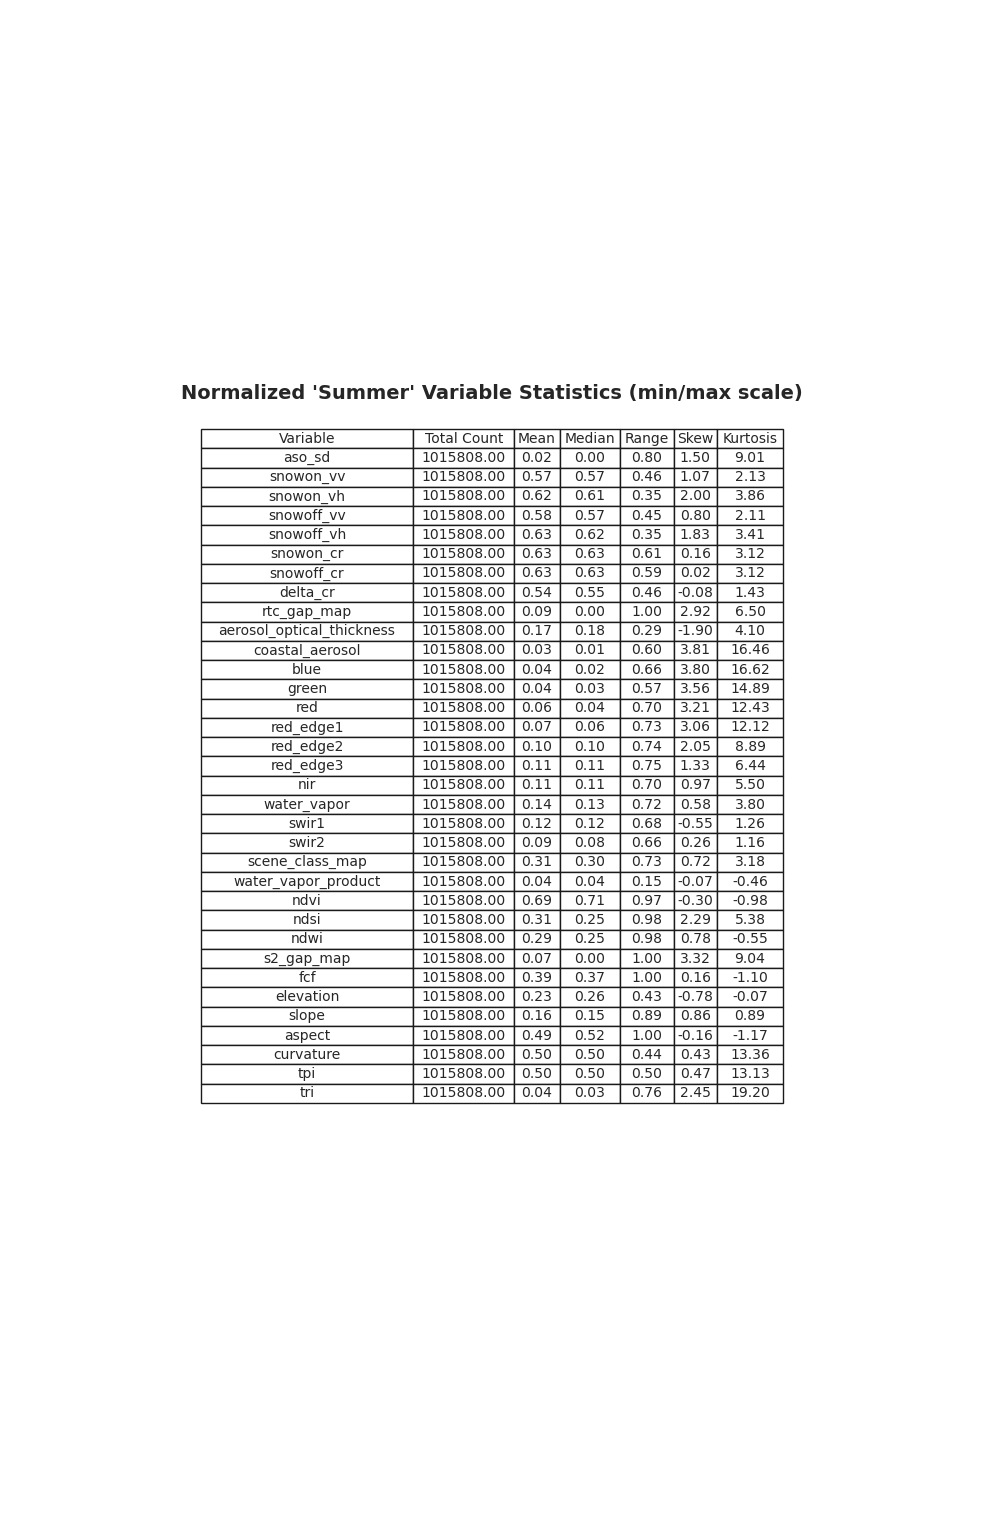

In [205]:
# Round the values in summary_df to 2 decimal points
summary_df[summary_df.select_dtypes(include=['float', 'int']).columns] = summary_df.select_dtypes(include=['float', 'int']).applymap(lambda x: f"{x:.2f}")
fig, ax = plt.subplots(figsize=(10, len(summary_df) * 0.5))  # Adjust height based on rows
ax.set_title("Normalized 'Summer' Variable Statistics (min/max scale)", fontsize=14, fontweight='bold', pad=-280)
ax.axis('off')
table = ax.table(cellText=summary_df.values, colLabels=summary_df.columns, cellLoc='center', loc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.auto_set_column_width(col=list(range(len(summary_df.columns))))
plt.tight_layout()
fig.subplots_adjust(top=0.9)
plt.savefig('/mnt/c/Users/JackE/uw/courses/aut24/ml_geo/final_data/WDA_data/images_hw6/norm_summer_stats.png', bbox_inches='tight', dpi=300)
plt.show()

In [206]:
# grab data paths
data_dir = '/mnt/c/Users/JackE/uw/courses/aut24/ml_geo/final_data/WDA_data/sum'
path_list = glob(f'{data_dir}/ASO_50M_SD*.nc')
# prepare training and validation dataloaders
train_data = deep_snow.dataset.Dataset(path_list, selected_channels, norm=False)
train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=1, shuffle=True)
# Initialize a dictionary to accumulate all data points for each variable across batches
data_aggregator = {var: [] for var in selected_channels if var != 'aso_gap_map' and var != 'latitude' and var != 'longitude' and var != 'dowy'}
data_aggregator.update({var: [] for var in ['aspect', 'slope', 'tpi']})
# Loop through the dataloader to aggregate data across all batches
for i, data_tuple in enumerate(train_loader):
    # Convert data_tuple to a dictionary and exclude unnecessary variables
    data_dict = {name: tensor.squeeze().numpy() for name, tensor in zip(selected_channels, data_tuple)
                 if name in data_aggregator}
    
    for var_name, data in data_dict.items():
        # Flatten the data and accumulate
        data_aggregator[var_name].extend(data.flatten())
# Compute summary statistics for each variable using the aggregated data
summary_data = []
for var_name, aggregated_data in data_aggregator.items():
    # Convert to a numpy array for consistent operations
    aggregated_data = np.array(aggregated_data)
    # Calculate statistics
    summary_data.append({
        'Variable': var_name,
        'Total Count': aggregated_data.size,
        'Mean': np.mean(aggregated_data),
        'Median': np.median(aggregated_data),
        'Range': np.ptp(aggregated_data),  # Peak-to-peak (max - min)
        'Skew': skew(aggregated_data, nan_policy='omit'),
        'Kurtosis': kurtosis(aggregated_data, nan_policy='omit')
    })
# Convert to a DataFrame
summary_df = pd.DataFrame(summary_data)

/tmp/ipykernel_24567/1526018247.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  summary_df[summary_df.select_dtypes(include=['float', 'int']).columns] = summary_df.select_dtypes(include=['float', 'int']).applymap(lambda x: f"{x:.2f}")


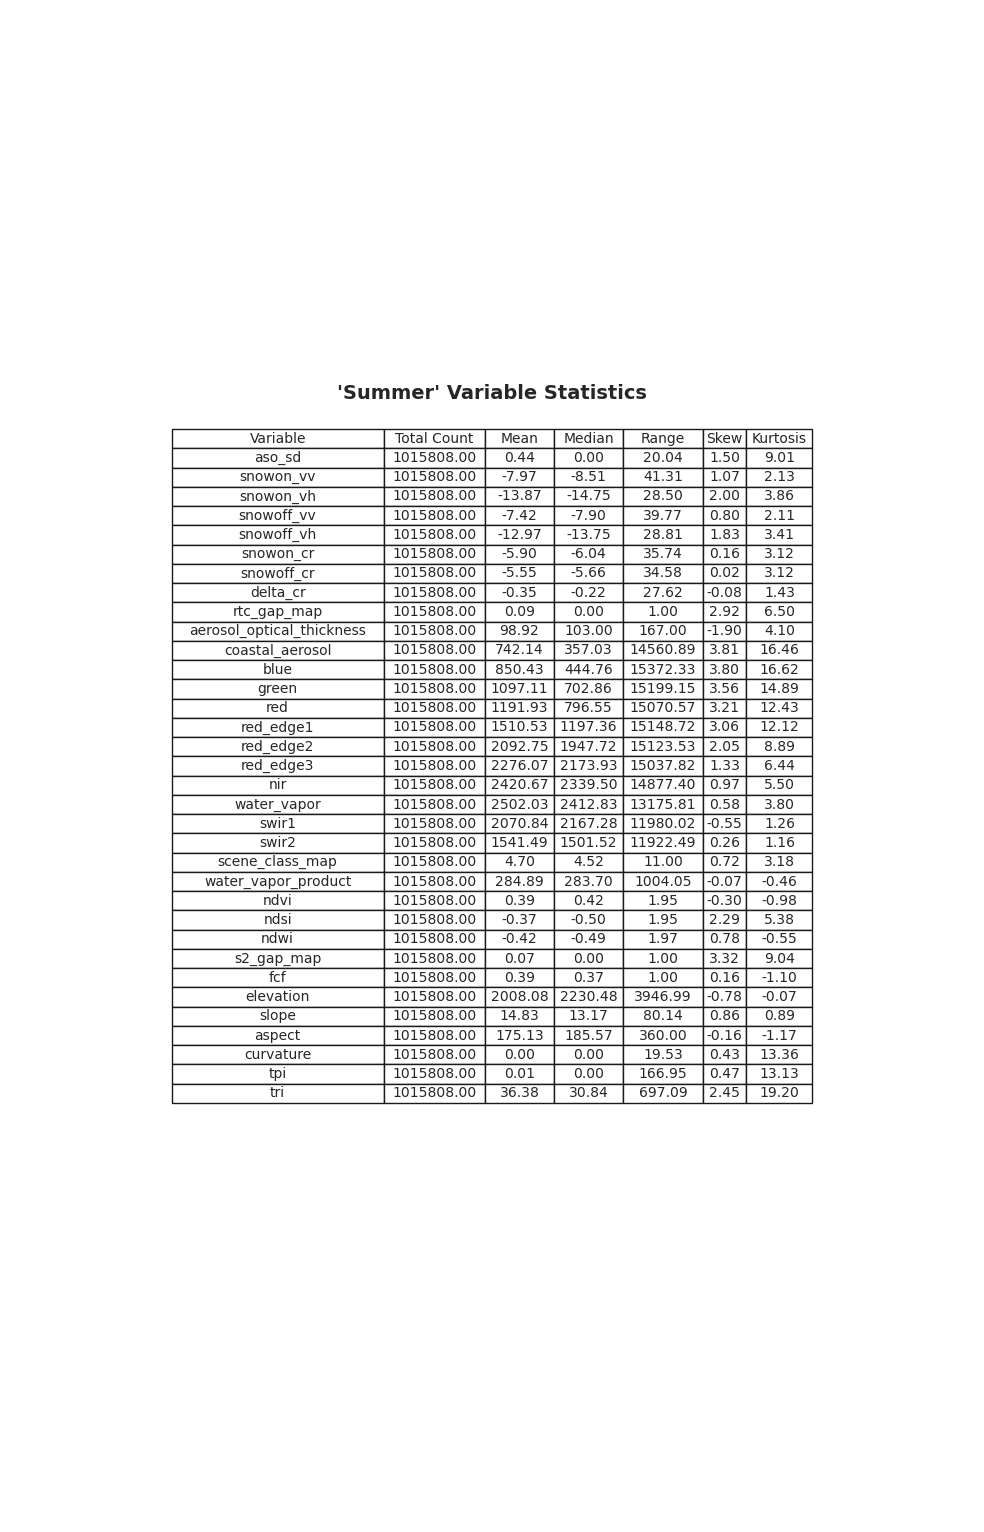

In [207]:
# Round the values in summary_df to 2 decimal points
summary_df[summary_df.select_dtypes(include=['float', 'int']).columns] = summary_df.select_dtypes(include=['float', 'int']).applymap(lambda x: f"{x:.2f}")
fig, ax = plt.subplots(figsize=(10, len(summary_df) * 0.5))  # Adjust height based on rows
ax.set_title("'Summer' Variable Statistics", fontsize=14, fontweight='bold', pad=-280)
ax.axis('off')
table = ax.table(cellText=summary_df.values, colLabels=summary_df.columns, cellLoc='center', loc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.auto_set_column_width(col=list(range(len(summary_df.columns))))
plt.tight_layout()
fig.subplots_adjust(top=0.9)
plt.savefig('/mnt/c/Users/JackE/uw/courses/aut24/ml_geo/final_data/WDA_data/images_hw6/summer_stats.png', bbox_inches='tight', dpi=300)
plt.show()